In [175]:
import numpy as np
from scipy import linalg, stats
import matplotlib.pyplot as plt

"""
Styling
See: http://matplotlib.org/users/customizing.html

TeX rendering:
You can use TeX to render all of your matplotlib text if the rc
parameter text.usetex is set.  This works currently on the agg and ps
backends, and requires that you have tex and the other dependencies
described at http://matplotlib.org/users/usetex.html
properly installed on your system.  The first time you run a script
you will see a lot of output from tex and associated tools.  The next
time, the run may be silent, as a lot of the information is cached in
~/.tex.cache
"""
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern'], 'size':16})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
# colors
BostonBlue = np.array([0., 104., 139.])/255
comp = np.array([200., 35., 0.])/255
# linewidth of plots
rc('lines', lw = 2)
# fontsize of the labels
rc('axes', labelsize = 16)
# bbox='tight' tries to make the bounding box fit the plot area
# pad_inches is the distance between the bounding box and the plot area
# see http://matplotlib.org/users/tight_layout_guide.html
rc('savefig', bbox = 'tight', pad_inches = .1)

# Wavepackets dynamics on the Fibonacci chain.


We diagonalize the hamiltonian. Then we can compute the propagator
$$K_{ij}(t) = <j|\exp(-i H t)|i>$$

The probability to be at site j at time t, given that the wavepacket was dropped at site i initially is then simply
$$P_i(j;t) = |K_{ij}(t)|^2$$
The quadratic displacement from initial site $i$ is
$$P_i(t) = \sum_j (x_j - x_i)^2 P_i(j;t).$$
We can generalize to arbitrary moments of the position operator:
$$P_i(t;q) = \sum_j (x_j - x_i)^q P_i(j;t).$$
We are here interested in the *average diffusion*, defined by
$$P(t;q) = \frac{1}{N}\sum_{i} P_i(t;q),$$ where $N$ is the system size.

In the long-time limit, for the periodic infinite chain, we observe the power law behaviour
$$P(t;q) \sim t^{q}$$
For the quasiperiodic Fibonacci chain, we expect the long-time behaviour to be a power law modulated by an oscillating function which will become $\log$-periodic in the strong quasiperiodicity ($\rho \rightarrow 0$) limit. We write:
$$P(t;q) \sim F\left( \log t \right) t^{q \sigma_q}.$$
We expect $\sigma_q < 1$. 
Actually, we have stronger bounds on $\sigma_q$. Guarneri showed that the quadratic coefficient is larger than the information dimension of the spectral measure:
$$ \sigma_2 \geq D_1^\mu. $$
Ketzmerick et al exhibited a more precise lower bound involving the dimensions of the spectral measure and the dimensions of its support:
$$ \sigma_q \geq D_2^\mu/D_2. $$

Piéchon conjuctured that $$\sigma_q = D_{1-q},$$ solely relating the power-law coefficient to the dimensions of the support of the spectral measure.
**Here we numerically test this conjecture.**

## Numerics
We use scipy linalg package to diagonalize the hamiltonian. We use the numpy.array structure for storage of the matrix.
(scipy.sparse.linalg.eigsh is designed for hamiltonian sparse matrices, which precisely what we have,
however it uses Lanczos algorithm, which typically only finds the highest eigenvalue with satisfying accuracy.)


Define the intensity matrix $I_{i,j}(t) = |K_{i,j}(t)|^2$, and the position matrix $X_{i,j}(q) = (x_j - x_i)^q$.
The average diffusion can be written as
$$ P(t;q) = \text{Tr}\left( X(q) I(t) \right). $$
Writing it in this form is advantageous because numpy is optimized for vector operations.

In [13]:
""" build the Fibonacci tight-binding hamiltonian """

# compute Fibonacci numbers
def fib(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + b
    return a

# inverse golden ratio
om = 2./(1.+np.sqrt(5))     

# jump amplitudes
def jump(n, i, tw, ts):
    p = fib(n-2)    
    q = fib(n-1)
    L = fib(n)    
    if(i*q % L < p):return ts
    else:return tw
    
# build the hamiltonian (free boundary conditions)
def h(n, rho):
    L = fib(n)
    h = np.zeros((L,L))
    for i in range(L-1): 
        h[i,i+1] = jump(n, i, rho, 1.)
        h[i+1,i] = h[i,i+1]
    return h
    
# build the hamiltonian (periodic boundary conditions)
def hp(n, rho):
    L = fib(n)    
    hp = np.zeros((L,L))
    for i in range(L-1): 
        hp[i,i+1] = jump(n, i, rho, 1.)
        hp[i+1,i] = hp[i,i+1]
        hp[0,L-1] = jump(n, L-1, rho, 1.)
        hp[L-1,0] = hp[0,L-1]
    return hp

def I(vec, t, x):
    """
    List of on-site presence probabilities at time t, starting from the localized state at site x
    vec: list of eigenstates
    """
    psi0 = vec[x]
    expH = np.array([np.exp(- 1j*t*e) for e in val])
    return abs(vec.dot(expH*psi0))**2

# matrix of the q-distances: D_{ij}(q) = |x_i-x_j|^q
dists = lambda q: np.fromfunction(lambda j,i: (np.minimum(abs(i-j),L-abs(i-j))/float(L))**q, (L, L))

def avP(vec, t, q):
    """
    Average (over all starting sites) expectation value for x^q(t), for a given list of eigenstates vec
    """
    # construct the matrix of intensities at time t
    Is = np.array([I(vec, t,j) for j in range(L)])
    
    return np.trace(np.dot(Is, dists(q)))/L

In [64]:
"""
Diagonalize the Hamiltonian
"""

# diagonalize
rho = .1
n = 13
L = fib(n)
val, vec = linalg.eigh(hp(n, rho))

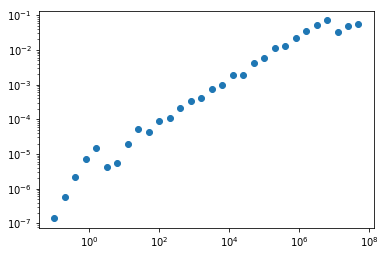

In [71]:
"""
Solve for the dynamics
"""
q = 2.
tRange = 10**np.arange(-1,8,.3)

p1 = [avP(vec, t, q) for t in tRange]

plt.loglog(tRange, p1, 'o')
plt.show()

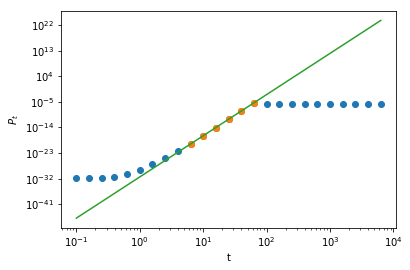

(1.0341801092320382, 0.0035093651894385386)

In [110]:
"""
Fit
"""

def fit(plist, pmin, pmax, plot = False):
    """
    /!\ return sigma = slope/q, ie sigma defined as <x(t)^q> ~ t^{q*sigma}
    """
    tRangeFit = tRange[pmin:pmax]
    plistFit = plist[pmin:pmax]
        
    # data in log-log scale
    logP = np.log(plistFit)
    logT = np.log(tRangeFit)
    slope, intercept, r_value, p_value, std_err = stats.linregress(logT,logP)
    
    if plot:
        plt.loglog(tRange, plist, 'o')
        plt.loglog(tRangeFit, plistFit, 'o')
        plt.loglog(tRange, np.exp(intercept)*tRange**slope, '-')
        plt.xlabel("t")
        plt.ylabel(r"$P_t$")
        plt.show()
    
    return slope/q, std_err/q

fit(p1, 9, 15, True)

We set manually the fitting area for each value of rho. Let us start with...
# $\rho = 0.9$

In [143]:
# diagonalize
rho = .9
n = 13
L = fib(n)
val, vec = linalg.eigh(hp(n, rho))

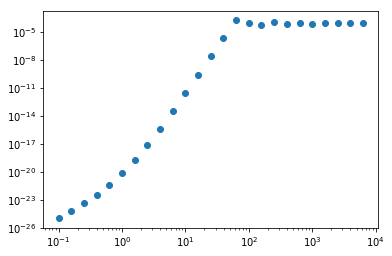

In [144]:
"""
Solve for the dynamics
"""
q = 10.
tRange = 10**np.arange(-1,4,.2)

p1 = [avP(vec, t, q) for t in tRange]

plt.loglog(tRange, p1, 'o')
plt.show()

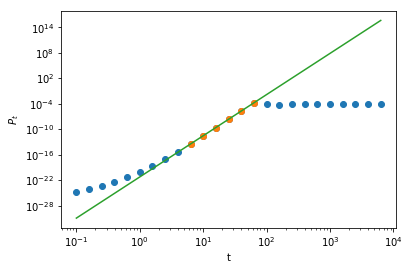

(0.97113448345136621, 0.0019307127737162768)

In [145]:
fit(p1, 9, 15, True)

In [147]:
qrange = np.arange(1., 15., 1.)

tRange = 10**np.arange(-1,4,.2)

sigmas09 = []
stds09 = []
for q in qrange:
    p = [avP(vec, t, q) for t in tRange]
    sigma, std = fit(p, 9, 15, False)
    sigmas09.append(sigma)
    stds09.append(std)

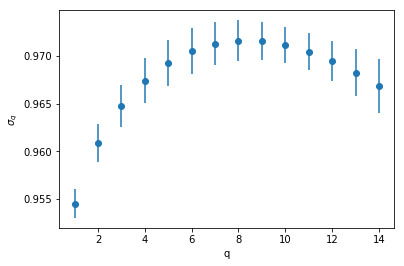

In [148]:
plt.errorbar(qrange, sigmas09, yerr=stds09, fmt='o')
plt.xlabel("q")
plt.ylabel(r"$\sigma_q$")
plt.show()

# Fractal dimensions of the spectrum ($\rho = 0.9$)

In [149]:
"""
D_q (computed with Mathematica, see notebook fractal_dimensions.nd)
"""
dq = np.array([[0, 0.953091], [-1, 0.960541], [-2, 0.96496], [-3, 0.96797], [-4, 
  0.970194], [-5, 0.971916], [-6, 0.973293], [-7, 0.974422], [-8, 
  0.97537], [-9, 0.976184], [-10, 0.976896], [-11, 0.977529], [-12, 
  0.9781], [-13, 0.97862], [-14, 0.979099]])
q, dq = dq.T

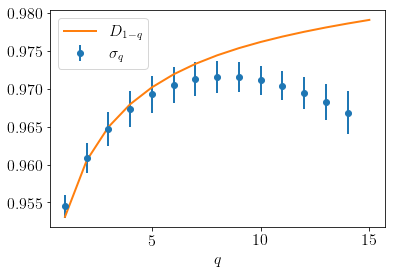

In [178]:
plt.errorbar(qrange, sigmas09, yerr=stds09, fmt='o')
plt.plot(1-q, dq, '-')
plt.legend((r"$D_{1-q}$", r"$\sigma_q$"))
plt.xlabel(r"$q$")
plt.savefig("diffusion_and_spectral_exponents_rho_09.pdf")
plt.show()

# $\rho = 0.9$, bigger system
Using a bigger chain allows us to compute the dynamics for a longer time. We check that this does not change significatively the $\sigma$ values.

In [136]:
# diagonalize
rho = .9
n = 15
L = fib(n)
val, vec = linalg.eigh(hp(n, rho))

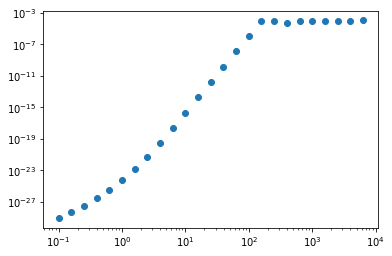

In [137]:
"""
Solve for the dynamics
"""
q = 10.
tRange = 10**np.arange(-1,4,.2)

p1 = [avP(vec, t, q) for t in tRange]

plt.loglog(tRange, p1, 'o')
plt.show()

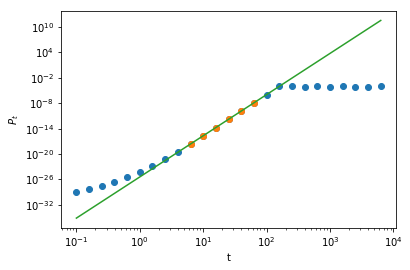

(0.97409688637647029, 0.00085452690226128726)

In [142]:
"""
We have two extra points to fit on, and these points do not change significatively the value of sigma.
"""
fit(p1, 9, 15, True)

# $\rho = 0.1$

In [151]:
"""
Diagonalize the Hamiltonian
"""

# diagonalize
rho = .1
n = 13
L = fib(n)
val, vec = linalg.eigh(hp(n, rho))

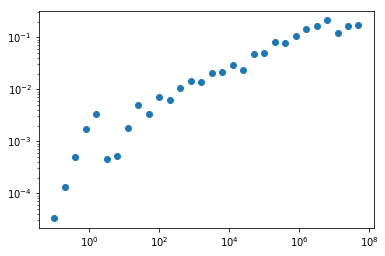

In [167]:
"""
Solve for the dynamics
"""
q = 1.
tRange = 10**np.arange(-1,8,.3)

p1 = [avP(vec, t, q) for t in tRange]

plt.loglog(tRange, p1, 'o')
plt.show()

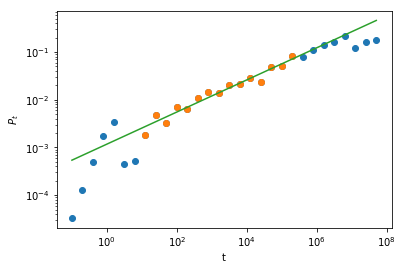

(0.33626329792905374, 0.021476113676176366)

In [168]:
fit(p1, 7, 22, True)

In [165]:
qrange = np.arange(1., 15., 1.)

tRange = 10**np.arange(-1,8,.3)

sigmas01 = []
stds01 = []
for q in qrange:
    p = [avP(vec, t, q) for t in tRange]
    sigma, std = fit(p, 9, 15, False)
    sigmas01.append(sigma)
    stds01.append(std)

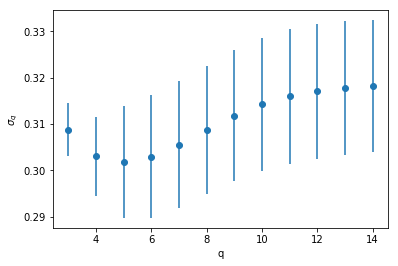

In [171]:
plt.errorbar(qrange[2:], sigmas01[2:], yerr=stds01[2:], fmt='o')
plt.xlabel("q")
plt.ylabel(r"$\sigma_q$")
plt.show()

# Fractal dimensions of the spectrum ($\rho = 0.1$)

In [173]:
dq01 = np.array([[0,0.3179954168448033],
[-1,0.31825054126953356],
[-2,0.31855096795033344],
[-3,0.31890233611121943],
[-4,0.3193099402918931],
[-5,0.31977877778399655],
[-6,0.3203135970355679],
[-7,0.3209189118064395],
[-8,0.3215989622272461],
[-9,0.32235761835418586],
[-10,0.32319823193499747],
[-11,0.3241234483509898],
[-12,0.3251349945450098],
[-13,0.32623346147310284],
[-14,0.32741810181706404]])
q, dq01 = dq01.T

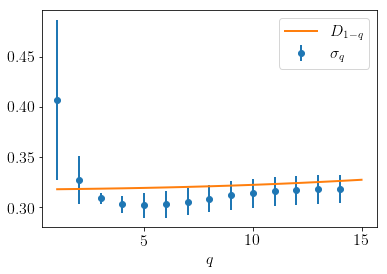

In [179]:
plt.errorbar(qrange, sigmas01, yerr=stds01, fmt='o')
plt.plot(1-q, dq01, '-')
plt.legend((r"$D_{1-q}$", r"$\sigma_q$"))
plt.xlabel(r"$q$")
plt.savefig("diffusion_and_spectral_exponents_rho_01.pdf")
plt.show()